# Why are some athletes more popular than others?
## Part II: Calculating sentiment towards players
In this project, I am using natural language processing (NLP) to try to understand what factors drive public opinion towards athletes. In [part 1](https://nbviewer.jupyter.org/github/map222/trailofpapers/blob/master/sentiment_sports/paper/scrape_reddit_covariates.ipynb), I showed how to use the pushShift API to scrape comment and like data off of the r/NBA and r/NFL sub-reddits; and how to download other auxiliary data on athletes. In this notebook, I will cover how I identified which players each comment was about; and how to calculate sentiments towards a player. In [part 3](https://nbviewer.jupyter.org/github/map222/trailofpapers/blob/master/sentiment_sports/paper/regression_sentiment.ipynb), I fit regression models to comment sentiment and votes in order to determine which features of an athlete are predictive of sentiment.

If you want to skip the "how" and just get to the results, skip below to the ["Sentiment results"](https://nbviewer.jupyter.org/github/map222/trailofpapers/blob/master/sentiment_sports/paper/calculating_player_sentiment.ipynb#results) section.

## What are entities and sentiment?
In this notebook I am going to use a lot of jargon from NLP. Before diving into how I calculated opinion towards players, let's review a few terms:
* Corpus: A corpus is a collection of documents
* Token: A token is a single word in a sentence (some models split single words into multiple tokens, or include separators as tokens)
* Named entity: In NLP, an "entity" is a noun. Thus a *named* entity is just a proper noun. The most common named entity in basketball right now is "LeBron."
* Named entity recognition (NER): The task of identifying which tokens in a sentence are named entities. A simple NER model would use things like capitalization to identify named entities. For example, "Nice assist by Wall," would identify the player John Wall rather than the wall of a building. More complex NER models use part-of-speech tagging or even neural nets to identify named entities.
* Sentiment analysis: The task of identifying whether a sentence or document is generally positive or negative. Simple models assign a positive or negative value to each word (e.g. "love" is a positive word). More complex models assign sentiment for each entity in a document. entiment models are typically trained to be effective for a specific task.

## How do we calculate the sentiment towards a player?
The data I scraped in part 1 constitutes a corpus of comments about NBA and NFL players. These comments range from short exclamations about specific players ("Cedi is the GOAT!"), to longer comments involving multiple named entities ("JR Smith threw a bowl of chicken tortilla soup at Damon Jones.").

Probably the most accurate way to calculate sentiment towards players would be to use a combined entity-sentiment model. These models parse each sentence for parts of speech and named entities, and assign sentiment towards each named entity. For example, a combined model could take "LeBron is better than Jordan," and assign positive sentiment to LeBron directly. However, those models are complex and slow, so I did not take that approach here.

Instead, I focused on sentences that contained just one named entity; then, for each sentence, I calculated that sentence's overall sentiment and linked it to the single entity. The downsides to this approach are: (1) I had to throw away information from sentences that contained multiple named entities; and (2) I had to assume the overall sentiment of a sentence reflects sentiment towards the player in the sentence. Fortunately, I had more than enough data to overcome the first obstacle. As for the second, I've found it to be generally true.

## Identifying which athletes a sentence is about
I took two broad approaches to named entity recognition. First, I tried using [Stanford's NER](https://nlp.stanford.edu/software/CRF-NER.shtml) package. My other approach was to use a known list of named entities (viz. NBA and NFL players' names), and then simply check to see if these names were present. In this section, I am going to demonstate both approaches on a small corpus. 

A re-usable version of  this process is in the function [`create_sentiment_df`](https://github.com/map222/trailofpapers/blob/sentiment_sports/sentiment_sports/sports_sentiment.py#L12) in the module [`sentiment_sports.py`](https://github.com/map222/trailofpapers/blob/sentiment_sports/sentiment_sports/sports_sentiment.py).
### Imports

In [ ]:
import pandas as pd
import numpy as np
from nltk import sent_tokenize
import string
import pandas as pd
import dask.dataframe as dd
from sner import Ner
from nltk import sent_tokenize
from fuzzywuzzy import process as fuzzy_process
from nltk.sentiment.vader import SentimentIntensityAnalyzer

In [8]:
import matplotlib.pyplot as plt
%matplotlib inline
fs = 14

### Chunking comments into sentences
The output of the Reddit scraping was full comments, which could contain multiple sentences. To get more samples, we can chunk the comments into sentences. I wrote the helper function [`chunk_comments_sentences`](https://github.com/map222/trailofpapers/blob/sentiment_sports/sentiment_sports/sports_sentiment.py#L72) to do just this. An example of this `pandas` processing is in the [Appendix](https://nbviewer.jupyter.org/github/map222/trailofpapers/blob/sentiment_sports/sentiment_sports/paper/calculating_player_sentiment.ipynb#appendix).

### Named entity recognition
Now that we have sentences, we can do NER two ways. First, we can do naive NER, where we don't know the entities ahead of time. Or we can do known NER, where we know what entities we care about
#### Stanford's NER tagger can be used for unknown NER
Stanford's NLP department has created a suite of NLP tools, including an NER Tagger. Running this tagger in python is quite slow, so I used a package called [`sner` from caihaoyu](https://github.com/caihaoyu/sner), which runs a Java server locally. To get this running, there are four steps:
1. Install sner (`pip install sner` worked for me, but you can see the package for details
2. Download the [Stanford NER package](https://nlp.stanford.edu/software/CRF-NER.shtml#Download), and unzip it in your preferred location. I usually do it under the `sner` package directory, e.g. `C:\Users\map22\Anaconda3\Lib\site-packages\sner\stanford-ner-2018-10-16`
3. Open a command prompt and navigate to that directory
4. Run the java server:

  `java -Djava.ext.dirs=./lib -cp stanford-ner.jar edu.stanford.nlp.ie.NERServer -port 9199 -loadClassifier ./classifiers/english.all.3class.distsim.crf.ser.gz  -tokenizerFactory edu.stanford.nlp.process.WhitespaceTokenizer -tokenizerOptions tokenizeNLs=false`

Once you have all that done, you can start tagging entities! For dataframes, I created the function [`extract_unknown_ner`](https://github.com/map222/trailofpapers/blob/sentiment_sports/sentiment_sports/sports_sentiment.py#L95). Here is an example of tagging a single sentence.

In [16]:
pos_tagger = Ner(host='localhost',port=9199)
pos_tagger.get_entities('Isaiah Thomas is the worst.' )

[('Isaiah', 'PERSON'),
 ('Thoms', 'PERSON'),
 ('is', 'O'),
 ('the', 'O'),
 ('worst.', 'O')]

The output of the NER tagger are tuples of (token, entity type), where entity type can be `PERSON`, `ORG`, or `O` for no entity. Here, both Isaiah and Thomas have been tagged as `PERSON` entities. What happens when we try to tag the Turkish player Cedi Osman?

In [21]:
pos_tagger.get_entities('Cedi is the GOAT!' )

[('Cedi', 'O'), ('is', 'O'), ('the', 'O'), ('GOAT!', 'O')]

Here, the tagger failed to tag Cedi. This is one of the major problems using off-the-shelf NER tools: they are trained and tuned to general applications, which may not transfer to the context you care about. The other major problem is that this tagger is sloooow. Even using a java server, it can take hours to extract entities from one year of data. This makes iterating and finding mistakes hard.

### NER using a known list
NER taggers are most useful in cases where you're not sure what the entities are, or you might find new named entities. Neither of those situations apply to us: we only care about NBA and NFL-related entities, and we already know those ahead of time!

Instead, I used the following algorithm to identify named entities in a sentence:
1. Get a set of all of the named entities you care about. For us, these are mainly player, team, and coach names.
2. For all names that match common English words (e.g. "Wall" or "Love"), find capitalized tokens. For example, this would recognize "assist by John Wall," but not "Tatum hit the rookie wall."
3. For all other names, just find a direct match. Most names are uncommon enough that they only match players.

For my dataframe processing, I wrote the function [`extract_known_ner`](https://github.com/map222/trailofpapers/blob/sentiment_sports/sentiment_sports/sports_sentiment.py#L122).

#### Example of tagging using known entities
Here's what this would look like for a toy dataset. First, we can create a small set of known entities, one of which we only want to recognize when capitalized ("Love").

In [44]:
# Use a set for fast lookup
UPPER_SET = {'Love', }
LOWER_SET = {'cedi', 'kevin', 'cavs', 'lebron'}

Here is our toy dataset:

In [45]:
toy_df = pd.DataFrame({'comment':['I love Cedi', 'Kevin Love is the best player on the Cavs now',
                                  'LeBron told Love to fit in, not fit out']})
toy_df

,comment
0,I love Cedi
1,Kevin Love is the best player on the Cavs now
2,"LeBron told Love to fit in, not fit out"


Next, we can extract the upper case matches to get the name "Love." Notice that the matching doesn't detect "love Cedi."

In [39]:
TEXT_COL = 'comment'
upper_filter = lambda sentence: [word for word in sentence.split() if word in UPPER_SET]
toy_df['upper_entities'] = toy_df[TEXT_COL].apply(upper_filter)
toy_df

,comment,upper_entities
0,I love Cedi,[]
1,Kevin Love is the best player on the Cavs now,[Love]
2,"LeBron told Love to fit in, not fit out",[Love]


Then we can extract the lower case entities and combine them with the upper case entities.

In [40]:
toy_df[TEXT_COL] = toy_df[TEXT_COL].str.lower()

# tokenize sentence with split, and use filter to find named entities
ner_filter = lambda sentence: [word for word in sentence.split() if word in LOWER_SET]
toy_df['lower_entities'] = toy_df[TEXT_COL].apply(ner_filter)
toy_df['combined_entities'] = toy_df.apply(lambda row: row['lower_entities'] + [word.lower() for word in row['upper_entities']], axis=1)
toy_df

,comment,upper_entities,lower_entities,combined_entities
0,i love cedi,[],[cedi],[cedi]
1,kevin love is the best player on the cavs now,[Love],"[kevin, cavs]","[kevin, cavs, love]"
2,"lebron told love to fit in, not fit out",[Love],[lebron],"[lebron, love]"


As I mentioned before the big advantage of the known tagger approach is that it is much faster than the tagger approach. However, it does have some drawbacks. First, it won't be able to recognize mispellings, or fun neonyms like "LeBronto." Second, it relies on us having a good list of known entities. Many players go by nicknames, so to detect those we will have to build a list, or lose those references.
### Comparing results from known and unknown NER methods
We can compare the two methods of detecting named entities by calculating the precision and recall on a small set of data. I hand-labeled ~50 sentences for the named entities in them. Then I tagged these sentences using both methods, and calculated the precision and recall (see [Appendix for code](https://nbviewer.jupyter.org/github/map222/trailofpapers/blob/sentiment_sports/sentiment_sports/paper/calculating_player_sentiment.ipynb#ner_performance). The known method had both higher precision (99% to 87%) and recall (88% to 46%), and was 4x faster as well.

### Identifying comments about one player
#### Filtering out comments with too many named entities
After extracting the named entities, we next have to tie them to a known player. I do this in two steps.

First, I filter out all sentences that don't contain any entities, and those sentences with more than two entities

In [41]:
toy_df = toy_df[toy_df['combined_entities'].str.len() > 0] # only care if we can find entity
toy_df = toy_df[toy_df['combined_entities'].str.len() < 3]
toy_df

,comment,upper_entities,lower_entities,combined_entities
0,i love cedi,[],[cedi],[cedi]
2,"lebron told love to fit in, not fit out",[Love],[lebron],"[lebron, love]"


To do this for dataframes, I wrote the functionn [`clean_entities`](https://github.com/map222/trailofpapers/blob/sentiment_sports/sentiment_sports/sports_sentiment.py#L145). 

#### Fuzzy matching the entities to players
At this point, we have sentences with 1-2 entities, and we have to figure out whether these entities match known players. For example, the single entity "Cedi" obviously refers to Cedi Osman, while a single entity like "Kevin" could mean Kevin Durant or Kevin Love. For sentences with two entities, we need to figure out whether they are referring to the same player ("LeBron James") or different players ("LeBron, Love").

To perform this task, I used fuzzy matching, which calculates the edit distance between two strings. It does this by looking for token matches, and substring matches. For this process, I used the package [`fuzzywuzzy`](https://github.com/seatgeek/fuzzywuzzy). The below function matches a potential player name against a list of known player names.

In [53]:
KNOWN_PLAYERS = {'lebron james', 'cedi osman', 'kevin love'}
def find_player( potential_name: str, unique_names: set ):
    ''' Fuzzy match an entity to one entity from a set

        potential_name: string name of an entity (e.g. a player name, like "lebron")
        unique_names: set of string player names ('first last') to be matched against
    '''
    names = fuzzy_process.extractBests(potential_name, unique_names, score_cutoff=87) # 87 means that "klay kd" matches nothing, but "curry" matches "stephen curry"
    
    # if there are more than 2 names, and they have the same score, no clear match
    if (len(names) > 1 and names[0][1] == names[1][1]) or len(names) == 0:
    # no clear match, return 'unclear match'
        return 'unclear'
    # there is only one similar name, or a clear top similar name
    return names[0][0]

To do the fuzzy matching, I first convert the list of entities into a single string, then apply the `find_player` function. If there is a clear match, the name is returned. If the match is unclear, "unclear" is returned.

In [56]:
toy_df['str_entities'] = toy_df['combined_entities'].str.join(' ')
toy_df['fuzzy_match'] = toy_df['str_entities'].apply(lambda names: find_player(names, KNOWN_PLAYERS))
toy_df[['comment', 'combined_entities', 'fuzzy_match']]

,comment,combined_entities,fuzzy_match
0,i love cedi,[cedi],cedi osman
2,"lebron told love to fit in, not fit out","[lebron, love]",unclear


We can then filter out sentences with an unclear name match

In [58]:
toy_df = toy_df.query('fuzzy_match != "unclear"')

#### Speeding up fuzzy matching with dask
The fuzzy matching is one of the most time consuming parts of the ETL pipeline, as it is basically O(N^2) (N sentences * M players). To speed it up I used [`dask`](http://docs.dask.org/en/latest/why.html) to parallelize my dataframe operations. For details, see the [appendix](https://nbviewer.jupyter.org/github/map222/trailofpapers/blob/sentiment_sports/sentiment_sports/paper/calculating_player_sentiment.ipynb#dask).
## Sentiment model
At this point, we now have a dataframe of sentences, each of which we have assigned to a single NBA or NFL player. Now we need to figure out whether the comments are positive or not!

As mentioned above, I use sentence-level sentiment analysis, and assume that the sentence level sentiment reflects the sentiment towards the player in the sentence. To calculate sentiment, I used probably the most famous sentiment analyzer out there, [VADER](http://www.nltk.org/howto/sentiment.html). VADER uses a pre-defined dictionary of sentiment for most common words in English (out-of-vocabulary words are given neutral sentiment). For example, the sentiment for the word "steal" is negative.

In [62]:
sid = SentimentIntensityAnalyzer()
sid.lexicon['steal']

-2.2

To get the overall sentiment for a sentence, VADER sums up the sentiment of each word in a sentence, then performs a [normalization step](https://github.com/cjhutto/vaderSentiment/blob/master/vaderSentiment/vaderSentiment.py#L105) to center the scores approximately between -1 and 1.
#### Updating the dictionary for sports
The sentiment for many sports related words is quite different from general usage. For example, "steal" is generally a negative word, but in the context of basketball is neutral. Luckily, it is relatively straightforward to update VADER's lexicon, as it is just a python dictionary.

In [63]:
stat_words = ['steal', 'steals', 'block', 'blocked', 'blocks', 'slam',
              'charges', 'rejection', 'free', 'assists', 'win']
sid.lexicon.update({word:0.0 for word in stat_words})

#### Applying the sentiment analyzer
This is as simple as calling the `polarity_scores` function on a sentence (and doing some pandas manipulation of the results).

In [70]:
intermediate_df = toy_df[TEXT_COL].apply( sid.polarity_scores )
sentiment_df = pd.DataFrame.from_dict(intermediate_df.tolist())
toy_df = toy_df.join(sentiment_df)
toy_df

,comment,upper_entities,lower_entities,combined_entities,str_entities,compound,neg,neu,pos
0,i love cedi,[],[cedi],[cedi],cedi,0.6369,0.0,0.192,0.808


The analyzer returns four values (in alphabetical order):
* compound: the overall sentiment for the sentence, combining positive, negative, and neutral
* neg: score for number of negative words in the sentence
* neu: score for neutral words
* pos: score for positive words

You can see in this instance there were only positive and neutral words, with the overall sentiment being positive.

## Sentiment results<a id='results'></a> 
Having described how I calculated sentiment, let's explore some real results. First, I'm going to load up `user_player_df`, which contains sentiment aggregated at the level of user and players. For example, the table below shows goodguysaul commented on Russell Westbrook 4 times in 2017, with mean sentiment of -0.11.

In [5]:
user_player_df = (pd.read_csv('c:/Users/map22/Google Drive/sentiment_nba/nba_user_player_sentiment.tsv', sep='\t')
                    .rename(columns={'compound_mean':'mean_sentiment'}))
user_player_df[['Player', 'user', 'season', 'comment_count', 'mean_sentiment']].sample(3)

,Player,user,season,comment_count,mean_sentiment
872599,rajon rondo,AnimeAdd1ct,2017,1,0.00000
777590,markelle fultz,InternetBecause,2017,1,0.44040
934328,russell westbrook,goodguysaul,2017,4,-0.11095


#### Most users have neutral sentiment towards a large minority of players
Let's look at the distribution of comment frequency at the user level (graph below, left). Here we can see that most users only comment once or twice on any given player; this makes sense as most people on reddit are lurkers, and comment infrequently. We can also look at the distribution of sentiment on the sentence level (graph below, right). A large minority of sentences contain neutral sentiment; the distribution of other sentences is skewed positive.

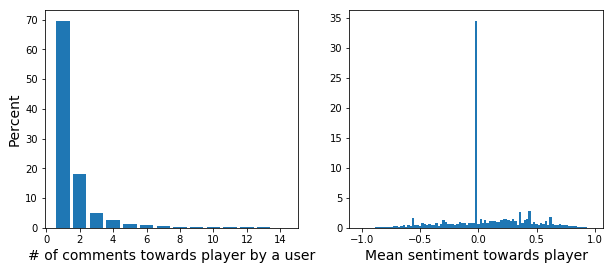

In [30]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=[10,4])
comment_hist, comment_bins = np.histogram(user_player_df['comment_count'], bins = np.arange(0.5, 15.5, 1))
sentiment_hist, sent_bins = np.histogram(user_player_df['mean_sentiment'], bins = np.arange(-1, 1, 0.02))
ax1.bar(comment_bins[:-1]+0.5,100* comment_hist / comment_hist.sum())
ax2.bar(sent_bins[:-1], 100* sentiment_hist / sentiment_hist.sum(), width = 0.02 )
ax1.set_xlabel('# of comments towards player by a user', fontsize = fs)
ax2.set_xlabel('Mean sentiment towards player', fontsize = fs);
ax1.set_ylabel('Percent', fontsize = fs);

#### Highest sentiment
We can then aggregate this data to get average sentiment towards players during each season (the data loaded in `nba_df` is available in the repo). The table below shows the five highest sentiment player-years since 2013. Looking at the highest sentiment players, we can see a collection of young players with potential... and Gordon Hayward. The idea that people like young players will come back again.

In [31]:
nba_df = (pd.read_csv('../modeling_data/nba_player_model_data.tsv', sep='\t')
            .rename(columns = {'compound_mean_mean':'mean_sentiment'}))
nba_df.query('user_count > 250').sort_values('mean_sentiment').tail(5).loc[::-1,['Player', 'season', 'mean_sentiment']]

,Player,season,mean_sentiment
1094,karl-anthony towns,2015,0.257979
702,gordon hayward,2014,0.244566
1303,malcolm brogdon,2017,0.237285
1302,malcolm brogdon,2016,0.234922
1055,josh hart,2017,0.229843


#### Lowest sentiment
On the low sentiment side, we can see two players famous for injuring superstars (Olynyk and Pachulia) at the top of the list.

In [18]:
nba_df.query('user_count > 250').sort_values('mean_sentiment').head(5)[['Player', 'season', 'mean_sentiment']]

,Player,season,mean_sentiment
1108,kelly olynyk,2016,-0.074903
2090,zaza pachulia,2017,-0.069070
1479,nene hilario,2014,-0.063163
1419,mike dunleavy,2014,-0.044450
1109,kelly olynyk,2017,-0.037742


#### Most commented players
Unsurprisingly, the most commented players were the best ones. All these players probably got a bump by playing deep into the playoffs.

In [25]:
nba_df.query('season ==2017').sort_values('user_count', ascending=False).head()[['Player', 'season', 'user_count', 'mean_sentiment']]

,Player,season,user_count,mean_sentiment
1263,lebron james,2017,12878,0.113354
1143,kevin durant,2017,6555,0.076652
821,james harden,2017,6343,0.093511
1843,stephen curry,2017,5969,0.142916
1224,kyrie irving,2017,4384,0.126036


#### Distribution of sentiment
We can look at how sentiment varies with player popularity. Here we can see the sentiment estimates are most variable for players with low comment count. There also doesn't seem to be any obvious bias for or against popular players.

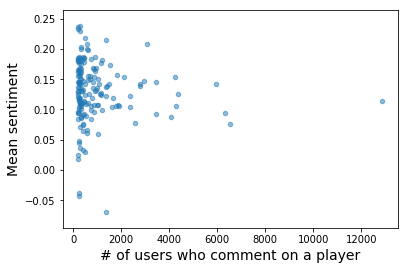

In [32]:
nba_df.query('user_count> 200 and season ==2017').plot('user_count', 'mean_sentiment', kind='scatter', alpha = 0.5)
#plt.plot([100, 100], [-0.1, 0.3])
plt.xlabel('# of users who comment on a player', fontsize = fs)
plt.ylabel('Mean sentiment', fontsize = fs);

## Exploration of covariates and sentiment
Finally, we can also start to explore correlations between sentiment and player attributes. In the interest of space, let's look at race and age. For the race graph, I have restricted the sample to players with at least 200 users commenting on them.

Standard deviation of sentiment for high comment players: 0.052963271203892465


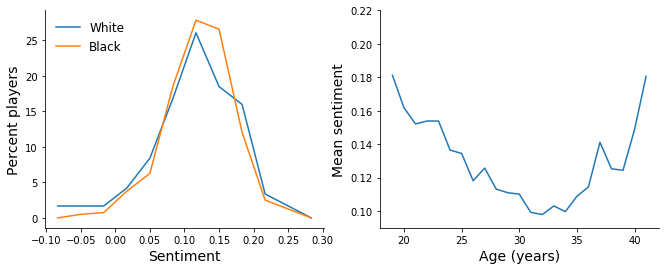

In [38]:
graph_df = nba_df.query('user_count > 200')
fig, (ax2, ax1) = plt.subplots(1,2, figsize = [11, 4])
nba_df.groupby('Age').mean().reset_index().plot('Age', 'mean_sentiment', ax = ax1);
#join_df.groupby('Ht').mean().reset_index().plot('Ht', 'compound_mean_mean', ax = ax2);
#plt.errorbar(['Black', 'White'], race_means, race_stds)
bin_width = 0.03333
sentiment_bins = np.arange(-0.1, 0.3, bin_width)
white_hist, _ = np.histogram(graph_df.query('Race == "W"')['mean_sentiment'], bins = sentiment_bins)
black_hist, _ = np.histogram(graph_df.query('Race == "B"')['mean_sentiment'], bins = sentiment_bins)
ax2.plot(sentiment_bins[:-1] + bin_width /2,100* white_hist / white_hist.sum() , label='White')
ax2.plot(sentiment_bins[:-1] + bin_width /2,100* black_hist / black_hist.sum() , label='Black')
ax1.set_ylabel('Mean sentiment', fontsize = fs)
ax1.set_xlabel('Age (years)', fontsize = fs)
ax2.set_xlabel('Sentiment', fontsize = fs)
ax2.set_ylabel('Percent players', fontsize = fs)
ax1.set_ylim([0.09, 0.22]);
ax2.legend(fontsize = fs-2, frameon=False, loc='upper left')
ax1.legend().remove()
ax1.spines['right'].set_visible(False)
ax1.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)
ax2.spines['top'].set_visible(False)
fig.savefig('Sentiment hist age.png',bbox_inches='tight', dpi=600)
print('Standard deviation of sentiment for high comment players: ' + str(graph_df['mean_sentiment'].std()))

On the left, we have plotted the distribution of sentiment for white and black players. Generally, they are pretty similar, although it appears black players might be slightly more popular.

On the right, we can plot the average sentiment by age. Younger and older players receive  higher sentiment.

Finally, for fun, we can do a scatter matrix of all sorts of covariates and sentiment. I won't go into detail about these, but you can see there's lots of collinearity!

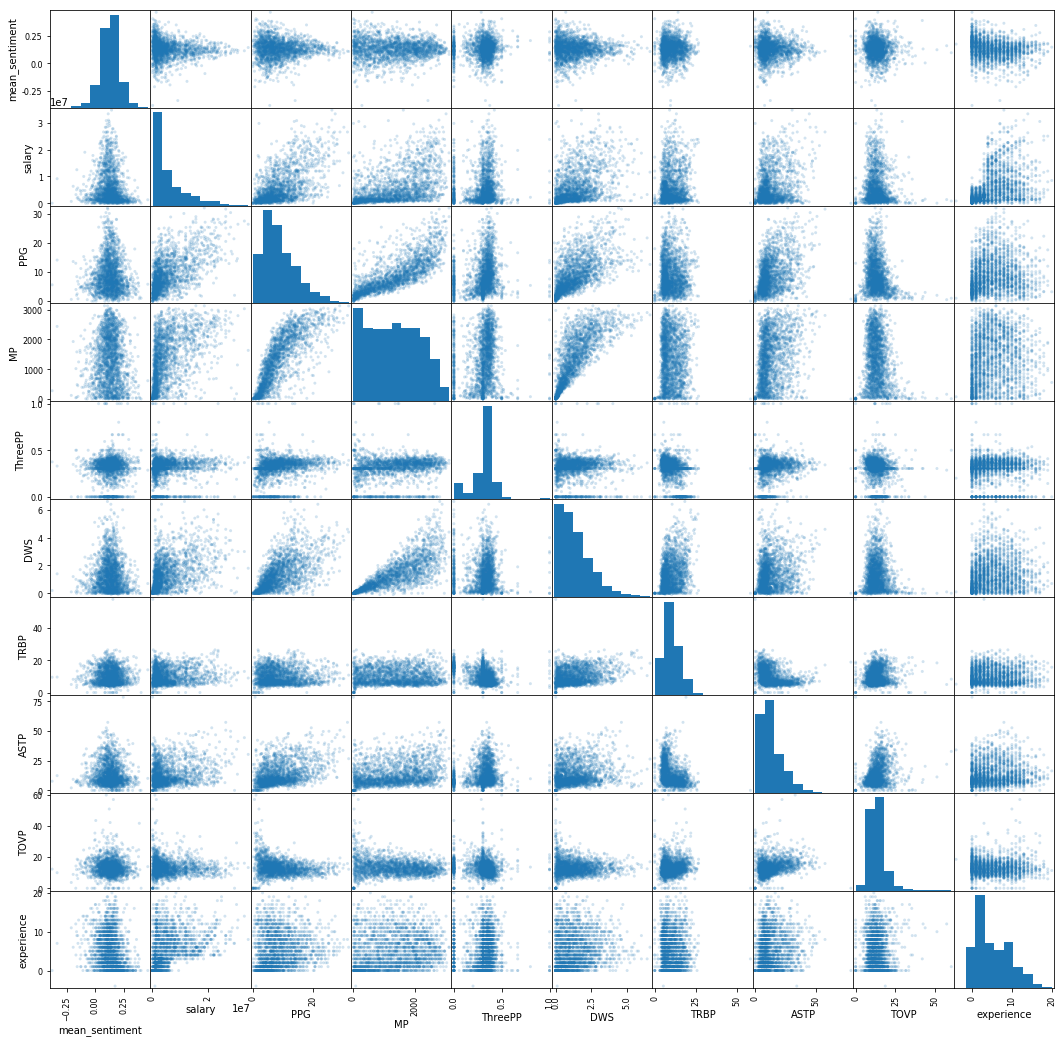

In [33]:
from pandas.plotting import scatter_matrix
scatter_matrix(nba_df[['mean_sentiment', 'salary',  'PPG', 'MP', 
                        'ThreePP', 'DWS', 'TRBP', 'ASTP', 'TOVP', 'experience']], alpha=0.2, figsize=(18, 18));

### Conclusion
In this notebook, I showed you how I extracted named entities (players) from Reddit comments, and calculated sentiment for those players. I also showed you some initial graphs of these results. If you'd like to take a look at the data yourself, you can download the [data off github](https://github.com/map222/trailofpapers/blob/sentiment_sports/sentiment_sports/modeling_data/nba_player_model_data.tsv). In part III, I will show how I used regression models to understand what covariates may influence sentiment.

## Appendix<a id='appendix'></a> 
### Example of chunking comments into sentences
First, let's start with a typical Cavs fan comment. I use `pandas` DataFrames for everything, so let's use one here.

In [11]:
comment_df = pd.DataFrame({'comment':['Cedi is the GOAT! Isaiah Thomas is the worst'],
                           'user': ['map222'], 'flair':'CLE'})
comment_df

,comment,flair,user
0,Cedi is the GOAT! Isaiah Thomas is the worst,CLE,map222


To tokenize, I used NLTK's `sent_tokenize` function. Since multiple sentences can be returned from a comment, I did some manipulation to get back a Series with a row for each sentence.

In [12]:
sentences_df = (comment_df['comment'].apply(lambda row: pd.Series(sent_tokenize(row)))
                                     .stack())
sentences_df

0  0             Cedi is the GOAT!
   1    Isaiah Thomas is the worst
dtype: object

We then need to do a bit more `pandas` manipulation to get a DataFrame where the index for each sentence is the same as its parent comment

In [13]:
sentences_df = (sentences_df.reset_index()
                  .set_index('level_0')
                  .rename(columns={0:'sentences'})
                  .drop(['level_1'], axis = 1))
sentences_df

,sentences
level_0,
0,Cedi is the GOAT!
0,Isaiah Thomas is the worst


Now that the index is sorted out, we can rejoin the sentences to the original comments, which allows us to retain metadata like the user and flair.

In [14]:
comment_df = (comment_df.join(sentences_df)
                        .drop(columns = ['comment']))
comment_df

,flair,user,sentences
0,CLE,map222,Cedi is the GOAT!
0,CLE,map222,Isaiah Thomas is the worst


### Comparing precision and recall for naive and known NER methods<a id='ner_performance'></a> 
#### Using Stanford tagger
Using the Stanford tagger is relatively straightforward. First, we need to start the Java server (see above). Then to do the tagging, we just need to call the function `extract_unknown_ner`.

First, some imports

In [1]:
import sys
sys.path.append("..")
data_path = 'd:/data/sentiment_sports/'
from sports_sentiment import extract_known_ner, extract_unknown_ner
from named_entities import NICKNAMES_OLDTIMERS, NON_PLAYERS

Next let's define our function for calculating precision and recall

In [28]:
def calc_pr(row):
    correct = set(row['labeled_entities'].lower().split())
    row['tp'] = sum(name in correct for name in row['named_entities'])
    row['fp'] = sum(name not in correct for name in row['named_entities'])
    row['fn'] = sum(name not in row['named_entities'] for name in correct)
    return row

Load the data

In [26]:
#load the test data
test_df = pd.read_csv('c:/Users/map22/Google Drive/sentiment_nba/sample_comments.tsv',
                    sep='\t')

Apply the tagger

In [ ]:
%%time
# takes approximately 360ms
unknown_df = ss.extract_unknown_ner(test_df.copy().head(100))
unknown_df = unknown_df[~unknown_df['labeled_entities'].isna()]

Calculate the precision and recall

In [38]:
unknown_df = unknown_df.apply(calc_pr, axis=1)
print('Total labeled named entities: ' + str(unknown_df['tp'].sum() + unknown_df['fn'].sum()))
print('Precision: ' + str(unknown_df['tp'].sum() / (unknown_df['tp'].sum() + unknown_df['fp'].sum())))
print('Recall: ' + str(unknown_df['tp'].sum() / (unknown_df['tp'].sum() + unknown_df['fn'].sum())))

Total labeled named entities: 85
Precision: 0.8666666666666667
Recall: 0.4588235294117647


The naive NER method had relatively high precision, but had disappointingly low recall. We will miss lots of player references with this method.
#### Known NER
Using the known NER method requires a bit of setup, as we need to initialize the list of players. We also need to import names of teams, non-players (executives, journalists), and remove some bad entities.

In [39]:
names_set = set([name for full_name in pd.read_csv('../modeling_data/nba_model_data.tsv',sep='\t')['Player'].tolist() for name in full_name.split()])
names_set = names_set.union(NICKNAMES_OLDTIMERS).union(NON_PLAYERS)
names_set = names_set - {'a', 'early'}
upper_set = {'Early'}

In [42]:
%%time
known_df = extract_known_ner(test_df.copy().head(100), names_set, upper_set, 'sentences', 'named_entities')
known_df = known_df[~known_df['labeled_entities'].isna()]

Wall time: 123 ms


In [41]:
known_df = known_df.apply(calc_pr, axis=1)
print('Precision: ' + str(known_df['tp'].sum() / (known_df['tp'].sum() + known_df['fp'].sum())))
print('Recall: ' + str(known_df['tp'].sum() / (known_df['tp'].sum() + known_df['fn'].sum())))

Precision: 0.9868421052631579
Recall: 0.8823529411764706


### Fuzzy matching using dask<a id='dask'></a> 
In my "production" code, I used `dask` to perform the fuzzy matching, in the function [`fuzzy_match_players`](https://github.com/map222/trailofpapers/blob/sentiment_sports/sentiment_sports/sports_sentiment.py#L189). Dask is a version of dataframes that allows for out-of-core computing for files that don't fit in memory; and more importantly for us, it allows for parallel processing. The way I use dask is relatively straightforward: I do all my work in pandas until I hit a particularly slow step. Then I convert my DataFrame from pandas to dask, do the slow step in parallel, then convert it back to pandas.

Here is what the code looks like. Before using dask, we define the extent of our parallelism: the number of CPUs to use, and the number of partitions.

In [ ]:
import dask as dd
num_workers = 8
num_partitions = int(2* num_workers - 1)

Since named entities are often duplicated, we extract the unique named entities, and create a single column dataframe.

In [ ]:
fuzzy_df = pd.DataFrame(sentiment_df[STR_COL].unique(), columns = [STR_COL])

Creating a dask dataframe is as simple as calling `from_pandas`.

In [ ]:
ddf = dd.from_pandas(fuzzy_df, npartitions=num_partitions)

Dask uses lazy execution. This means that it doesn't execute code unless you force it to. So to do our fuzzy matching, we need to define what we want dask to do using `map_partitions()`, then force execution using `compute()`

In [ ]:
ddf['fuzzy_name'] = ddf.map_partitions(lambda df: df['str_entities'].apply(lambda row: find_player(row, UNIQUE_NAMES) ) )
fuzzy_df = ddf.compute(num_workers=num_workers, scheduler='processes')

Finally, since we only got fuzzy matches for unique names, we need to join it back onto our original dataframe.

In [ ]:
sentiment_df = sentiment_df.merge(fuzzy_df, on=STR_COL)